# Regularized Regression

In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

boston = datasets.load_boston()
X = boston['data']
y = boston['target']

Before building the `RegularizedRegression` class, let's define a few helper functions. The first function standardizes the data by removing the mean and dividing by the standard deviation. This is the equivalent of the `StandardScaler` from `scikit-learn`.

The `sign` function simply returns the sign of each element in an array. This is useful for calculating the gradient in Lasso regression. The `first_element_zero` option makes the function return a 0 (rather than a -1 or 1) for the first element. As discussed in the {doc}`concept section </content/c2/s1/regularized>`, this prevents Lasso regression from penalizing the magnitude of the intercept. 


In [7]:
def standard_scaler(X):
    means = X.mean(0)
    stds = X.std(0)
    return (X - means)/stds

def sign(x, first_element_zero = False):
    signs = (-1)**(x < 0)
    if first_element_zero:
        signs[0] = 0
    return signs

The `RegularizedRegression` class below contains methods for fitting Ridge and Lasso regression. The first method, `record_info`, handles standardization, adds an intercept to the predictors, and records the necessary values. The second, `fit_ridge`, fits Ridge regression using

$$
\hat{\bbeta} = \left( \bX^\top \bX + \lambda I'\right) ^{-1} \bX^\top \by.
$$

The third method, `fit_lasso`, estimates the regression parameters using gradient descent. The gradient is the derivative of the Lasso loss function:

$$
\dadb{L(\bbetahat)}{\bbetahat} = - \bX^\top\left( \by - \bX \bbetahat \right) + \lambda I'\text{ sign}(\bbetahat).
$$

The gradient descent used here simply adjusts the parameters a fixed number of times (determined by `n_iters`). There many more efficient ways to implement gradient descent, though we use a simple implementation here to keep focus on Lasso regression. 

In [8]:
class RegularizedRegression:
        
    def _record_info(self, X, y, lam, intercept, standardize):
        
        # standardize 
        if standardize == True: 
            X = standard_scaler(X)
        
        # add intercept
        if intercept == False: 
            ones = np.ones(len(X)).reshape(len(X), 1) # column of ones 
            X = np.concatenate((ones, X), axis = 1) # concatenate
            
        # record values
        self.X = np.array(X)
        self.y = np.array(y)
        self.N, self.D = self.X.shape
        self.lam = lam
        
    def fit_ridge(self, X, y, lam = 0, intercept = False, standardize = True):
        
        # record data and dimensions
        self._record_info(X, y, lam, intercept, standardize)
        
        # estimate parameters
        XtX = np.dot(self.X.T, self.X)
        I_prime = np.eye(self.D)
        I_prime[0,0] = 0 
        XtX_plus_lam_inverse = np.linalg.inv(XtX + self.lam*I_prime)
        Xty = np.dot(self.X.T, self.y)
        self.beta_hats = np.dot(XtX_plus_lam_inverse, Xty)
        
        # get fitted values
        self.y_hat = np.dot(self.X, self.beta_hats)
        
        
    def fit_lasso(self, X, y, lam = 0, n_iters = 2000,
                  lr = 0.0001, intercept = False, standardize = True):

        # record data and dimensions
        self._record_info(X, y, lam, intercept, standardize)
        
        # estimate parameters
        beta_hats = np.random.randn(self.D)
        for i in range(n_iters):
            dL_dbeta = -self.X.T @ (self.y - (self.X @ beta_hats)) + self.lam*sign(beta_hats, True)
            beta_hats -= lr*dL_dbeta 
        self.beta_hats = beta_hats
        
        # get fitted values
        self.y_hat = np.dot(self.X, self.beta_hats)


The following cell runs Ridge and Lasso regression for the {doc}`Boston housing</content/appendix/data>` dataset. For simplicity, we somewhat arbitrarily choose $\lambda = 10$—in practice, this value should be chosen through cross validation.

In [9]:
# set lambda
lam = 10

# fit ridge
ridge_model = RegularizedRegression()
ridge_model.fit_ridge(X, y, lam)

# fit lasso
lasso_model = RegularizedRegression()
lasso_model.fit_lasso(X, y, lam)


The below graphic shows the coefficient estimates using Ridge and Lasso regression with a changing value of $\lambda$. Note that $\lambda = 0$ is identical to ordinary linear regression. As expected, the magnitude of the coefficient estimates decreases as $\lambda$ increases. 

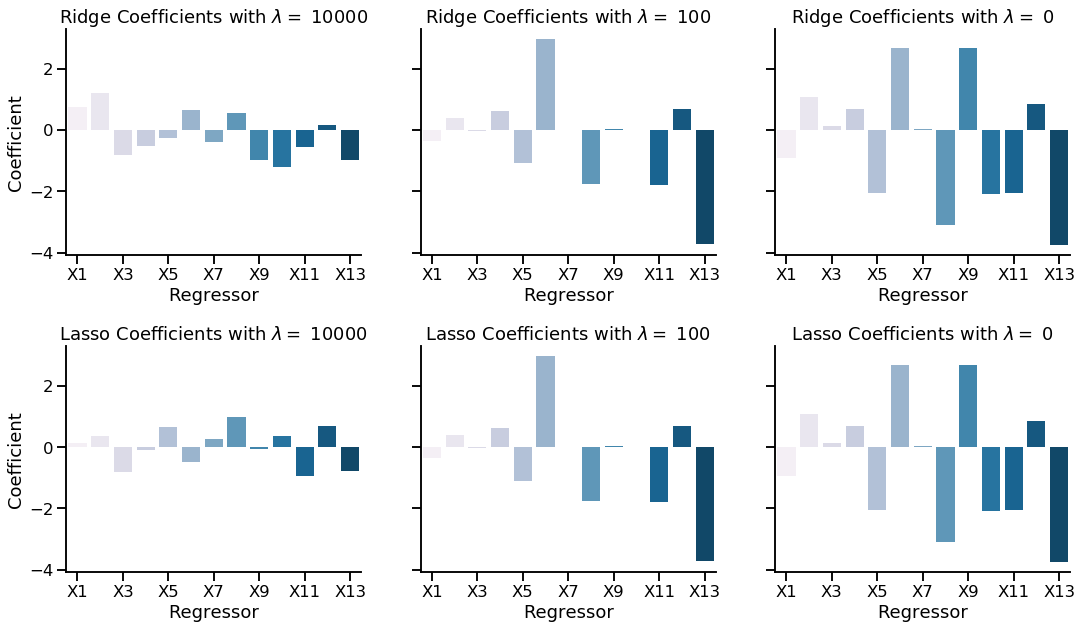

In [10]:
Xs = ['X'+str(i + 1) for i in range(X.shape[1])]
lams = [10**4, 10**2, 0]

fig, ax = plt.subplots(nrows = 2, ncols = len(lams), figsize = (6*len(lams), 10), sharey = True)
for i, lam in enumerate(lams):
    
    ridge_model = RegularizedRegression()
    ridge_model.fit_lasso(X, y, lam) 
    ridge_betas = ridge_model.beta_hats[1:]
    sns.barplot(Xs, ridge_betas, ax = ax[0, i], palette = 'PuBu')
    ax[0, i].set(xlabel = 'Regressor', title = fr'Ridge Coefficients with $\lambda = $ {lam}')
    ax[0, i].set(xticks = np.arange(0, len(Xs), 2), xticklabels = Xs[::2])
    
    lasso_model = RegularizedRegression()
    lasso_model.fit_lasso(X, y, lam) 
    lasso_betas = lasso_model.beta_hats[1:]
    sns.barplot(Xs, lasso_betas, ax = ax[1, i], palette = 'PuBu')
    ax[1, i].set(xlabel = 'Regressor', title = fr'Lasso Coefficients with $\lambda = $ {lam}')
    ax[1, i].set(xticks = np.arange(0, len(Xs), 2), xticklabels = Xs[::2])

ax[0,0].set(ylabel = 'Coefficient')
ax[1,0].set(ylabel = 'Coefficient')
plt.subplots_adjust(wspace = 0.2, hspace = 0.4)
sns.despine()
sns.set_context('talk');